# Perhitungan Skor RNN-IDS

## Import All Necessary Libraries

In [26]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math

## Load All the Data

In [27]:
df_pred = pd.read_csv('/home/apta/neuralnetwork-AD/rnn-apta/results/vector/Monday-WorkingHours_training_465/result-lstm-tcp465-hl2-seq3-do0.2-oov1000-Friday-WorkingHours_testing_465.csv', 
                      names=['id', 'binary_error', 'b_mean', 'b_iqr', 'b_zscore', 'floatin_error', 'f_mean', 'f_iqr', 'f_zscore'])

df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Friday-WorkingHours.pcap_ISCX.csv', 
                       encoding='ISO-8859-1')


In [28]:
df_pred.head()

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore
0,192.168.10.9-1065-173.194.66.108-465-tcp,0.035482,0,0,0,4721.725689,0,0,0
1,192.168.10.25-49169-173.194.66.109-465-tcp,0.033388,0,0,0,4822.395102,0,0,0
2,192.168.10.5-49230-173.194.66.108-465-tcp,0.036930,0,0,0,4627.227866,0,0,0
3,192.168.10.8-1132-173.194.66.109-465-tcp,0.036630,0,0,0,6373.630690,1,0,0
4,192.168.10.16-54934-74.125.22.109-465-tcp,0.032632,0,0,0,4319.312500,0,0,0


In [29]:
df_truth.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


## Exploratory Data Analysis

In [30]:
df_truth[[' Label']].value_counts()

 Label  
BENIGN      414322
PortScan    158930
DDoS        128027
Bot           1966
Name: count, dtype: int64

In [31]:
df_pred[['b_iqr']].value_counts()

b_iqr
0        360
Name: count, dtype: int64

In [32]:
df_pred[['b_zscore']].value_counts()

b_zscore
0           360
Name: count, dtype: int64

In [33]:
df_truth.isnull().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64

## Data Pre-Processing

### Convert the type of the data

In [34]:
df_truth.columns = df_truth.columns.str.strip()  # remove leading/trailing spaces
df_truth.columns = df_truth.columns.str.replace(' ', '_')  # optional: make them easier to type

df_truth['Source_Port'] = pd.to_numeric(df_truth['Source_Port'], errors='coerce')
df_truth['Destination_Port'] = pd.to_numeric(df_truth['Destination_Port'], errors='coerce')

# Optionally: drop rows with NaN in these columns
df_truth.dropna(subset=['Source_Port', 'Destination_Port'], inplace=True)

# Filter to only include rows where either port is 465
df_truth = df_truth[(df_truth['Source_Port'] == 465) | (df_truth['Destination_Port'] == 465)]

# Now you can safely convert to int
df_truth['Source_Port'] = df_truth['Source_Port'].astype(int)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(int)


df_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 885 entries, 385 to 703218
Data columns (total 85 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow_ID                      885 non-null    object 
 1   Source_IP                    885 non-null    object 
 2   Source_Port                  885 non-null    int64  
 3   Destination_IP               885 non-null    object 
 4   Destination_Port             885 non-null    int64  
 5   Protocol                     885 non-null    int64  
 6   Timestamp                    885 non-null    object 
 7   Flow_Duration                885 non-null    int64  
 8   Total_Fwd_Packets            885 non-null    int64  
 9   Total_Backward_Packets       885 non-null    int64  
 10  Total_Length_of_Fwd_Packets  885 non-null    int64  
 11  Total_Length_of_Bwd_Packets  885 non-null    float64
 12  Fwd_Packet_Length_Max        885 non-null    int64  
 13  Fwd_Packet_Length_Mi

In [35]:
df_truth['Label'].value_counts()

Label
BENIGN      725
PortScan    160
Name: count, dtype: int64

In [36]:
df_truth['Label'].head()

385     BENIGN
386     BENIGN
460     BENIGN
461     BENIGN
1587    BENIGN
Name: Label, dtype: object

In [37]:
df_truth['Source_Port'] = df_truth['Source_Port'].astype(str)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(str)

df_truth['Protocol'] = pd.to_numeric(df_truth['Protocol'], errors='coerce')  
df_truth.dropna(subset=['Protocol'], inplace=True)                      
df_truth['Protocol'] = df_truth['Protocol'].astype(int).astype(str)         

protocol_map = {
    '6': 'tcp',
    '17': 'udp',
    '1': 'icmp',
    '0': 'other'  # fallback or unknown
}

# Convert 'Protocol' number to string using the mapping
def map_protocol(protocol):
    return protocol_map.get(protocol, 'other')

# Apply the conversion for 'Protocol' and concatenate the 'id'
df_truth['id'] = df_truth[['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol']]\
    .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)

/tmp/ipykernel_402425/691346611.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)


## Making Predictions

In [38]:
df_pred["id"]

0         192.168.10.9-1065-173.194.66.108-465-tcp
1       192.168.10.25-49169-173.194.66.109-465-tcp
2        192.168.10.5-49230-173.194.66.108-465-tcp
3         192.168.10.8-1132-173.194.66.109-465-tcp
4        192.168.10.16-54934-74.125.22.109-465-tcp
                          ...                     
355    192.168.10.12-54870-173.194.207.108-465-tcp
356    192.168.10.17-42194-173.194.207.109-465-tcp
357    192.168.10.14-58642-173.194.207.108-465-tcp
358    192.168.10.15-59815-173.194.207.109-465-tcp
359     192.168.10.16-56710-209.85.201.108-465-tcp
Name: id, Length: 360, dtype: object

In [39]:
df_truth["id"]

385       192.168.10.16-57100-209.85.232.108-465-tcp
386       192.168.10.16-57100-209.85.232.108-465-tcp
460       192.168.10.17-33856-209.85.232.108-465-tcp
461       192.168.10.17-33856-209.85.232.108-465-tcp
1587        192.168.10.9-8935-209.85.232.109-465-tcp
                             ...                    
702702      192.168.10.5-52368-74.125.22.108-465-tcp
702961     192.168.10.14-53227-74.125.22.109-465-tcp
702965     192.168.10.14-53227-74.125.22.109-465-tcp
703215       192.168.10.9-6491-74.125.22.109-465-tcp
703218       192.168.10.9-6491-74.125.22.109-465-tcp
Name: id, Length: 885, dtype: object

In [40]:
# Convert 'Label' column to numeric: BENIGN -> 0, other -> 1
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [41]:
# df_pred["Label"] = np.where(df_pred["id"].isin(df_truth["id"]), 1, 0)

df_pred = df_pred.merge(df_truth[['id', 'Label']], on='id', how='left')
df_pred = df_pred.dropna(subset=['Label'])

In [42]:
# df_pred[df_pred['Label'] == 1].to_csv('filtered_predictions-1-80-friday.csv', index=False)

df_pred[df_pred['Label']==1]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label


In [43]:
# df_pred[df_pred['Label'] == 0].to_csv('filtered_predictions-0-80-friday.csv', index=False)

df_pred[df_pred['Label']==0]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.9-1065-173.194.66.108-465-tcp,0.035482,0,0,0,4721.725689,0,0,0,0
1,192.168.10.9-1065-173.194.66.108-465-tcp,0.035482,0,0,0,4721.725689,0,0,0,0
2,192.168.10.25-49169-173.194.66.109-465-tcp,0.033388,0,0,0,4822.395102,0,0,0,0
3,192.168.10.25-49169-173.194.66.109-465-tcp,0.033388,0,0,0,4822.395102,0,0,0,0
4,192.168.10.5-49230-173.194.66.108-465-tcp,0.036930,0,0,0,4627.227866,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
701,192.168.10.14-58642-173.194.207.108-465-tcp,0.027917,0,0,0,1881.684362,0,1,0,0
702,192.168.10.15-59815-173.194.207.109-465-tcp,0.030780,0,0,0,3787.065280,0,0,0,0
703,192.168.10.15-59815-173.194.207.109-465-tcp,0.030780,0,0,0,3787.065280,0,0,0,0
704,192.168.10.16-56710-209.85.201.108-465-tcp,0.031184,0,0,0,4770.718750,0,0,0,0


In [44]:
df_pred

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.9-1065-173.194.66.108-465-tcp,0.035482,0,0,0,4721.725689,0,0,0,0
1,192.168.10.9-1065-173.194.66.108-465-tcp,0.035482,0,0,0,4721.725689,0,0,0,0
2,192.168.10.25-49169-173.194.66.109-465-tcp,0.033388,0,0,0,4822.395102,0,0,0,0
3,192.168.10.25-49169-173.194.66.109-465-tcp,0.033388,0,0,0,4822.395102,0,0,0,0
4,192.168.10.5-49230-173.194.66.108-465-tcp,0.036930,0,0,0,4627.227866,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
701,192.168.10.14-58642-173.194.207.108-465-tcp,0.027917,0,0,0,1881.684362,0,1,0,0
702,192.168.10.15-59815-173.194.207.109-465-tcp,0.030780,0,0,0,3787.065280,0,0,0,0
703,192.168.10.15-59815-173.194.207.109-465-tcp,0.030780,0,0,0,3787.065280,0,0,0,0
704,192.168.10.16-56710-209.85.201.108-465-tcp,0.031184,0,0,0,4770.718750,0,0,0,0


In [45]:
df_pred[['Label']].value_counts()

Label
0        706
Name: count, dtype: int64

In [46]:
import os
# Define the directory path
dir_path = '../mcnemar/http'

# Check if the directory exists, and if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

df_temp = df_pred[['id', 'b_mean','b_iqr', 'b_zscore', 'f_zscore', 'f_mean','f_iqr' ]]
df_temp.to_csv(os.path.join(dir_path, 'pred_0.0.csv'))

## Calculating Score

In [47]:
threshold = ['b_mean', 'b_iqr', 'b_zscore']
threshold_2 = ['f_mean', 'f_iqr', 'f_zscore']

methods = ['binary', 'floating']

In [48]:
df_pred[['b_zscore']]

,b_zscore
0,0
1,0
2,0
3,0
4,0
...,...
701,0
702,0
703,0
704,0


### Detection Rate

In [49]:
from sklearn.metrics import recall_score

score = dict()
score['Detection Rate'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = recall_score(df_pred['Label'], df_pred[i].astype(int))
            score['Detection Rate'][i] = acc
            print(f'Recall-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = recall_score(df_pred['Label'], df_pred[i].astype(int))
            score['Detection Rate'][i] = acc
            print(f'Recall-Floating-{i}: {acc}')  

Recall-Binary-b_mean: 0.0
Recall-Binary-b_iqr: 0.0
Recall-Binary-b_zscore: 0.0
Recall-Floating-f_mean: 0.0
Recall-Floating-f_iqr: 0.0
Recall-Floating-f_zscore: 0.0


/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:15

### Confussion Matrix

/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

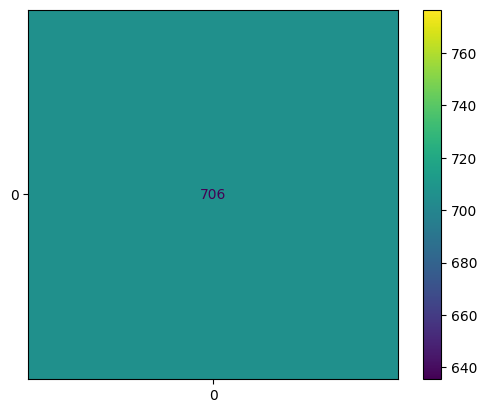

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method in methods:
    if method == 'binary':
        for i in threshold:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i].astype(int))
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Binary - {i.strip()}')
            plt.show()
    else:
        for i in threshold_2:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i].astype(int))
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Floating - {i.strip()}')
            plt.show()


### F2-Score

In [51]:
score['F2 Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Binary-{i}: {f2}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Floating-{i}: {f2}')

/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: not enough values to unpack (expected 4, got 1)

### FPR Score

In [52]:
score['FPR Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Binary-{i}: {fpr}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Floating-{i}: {fpr}')

/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: not enough values to unpack (expected 4, got 1)

In [53]:
from sklearn.metrics import accuracy_score

score['Accuracy Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = accuracy_score(df_pred['Label'], df_pred[i].astype(int))
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = accuracy_score(df_pred['Label'], df_pred[i].astype(int))
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Floating-{i}: {acc}')  

Accuracy-Binary-b_mean: 1.0
Accuracy-Binary-b_iqr: 1.0
Accuracy-Binary-b_zscore: 1.0
Accuracy-Floating-f_mean: 0.9830028328611898
Accuracy-Floating-f_iqr: 0.9858356940509915
Accuracy-Floating-f_zscore: 0.9971671388101983


In [54]:
df_score = pd.DataFrame.from_dict(score)
df_score

,Detection Rate,F2 Score,FPR Score,Accuracy Score
b_mean,0.0,NaN,NaN,1.000000
b_iqr,0.0,NaN,NaN,1.000000
b_zscore,0.0,NaN,NaN,1.000000
f_mean,0.0,NaN,NaN,0.983003
f_iqr,0.0,NaN,NaN,0.985836
f_zscore,0.0,NaN,NaN,0.997167


In [55]:
df_score.to_excel('score_ftp_0.0.xlsx')

In [56]:
# %pip install openpyxl